In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [126]:
import pandas as pd
import cv2
import glob
import pydicom
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, concatenate, BatchNormalization
from keras.models import Model
from keras.utils import to_categorical

In [4]:
PATH = "/home/jeff/notebooks/kaggle/pneumonia/"

In [9]:
df_labels = pd.read_csv('data/stage_1_train_labels.csv')

There are more than 1 bounding boxes per image

In [261]:
np.max(df_labels.groupby(['patientId']).size())

4

In [272]:
df_labels['patientId'].unique().shape

(25684,)

In [286]:
df_labels[['patientId','Target']].drop_duplicates().shape

(25684, 2)

Let's get the largest bounding box per image

In [301]:
df_labels['area'] = df_labels['width']*df_labels['height']

In [455]:
df_labels.groupby(['patientId','Target'])['area'].agg(np.max).reset_index().shape

(25684, 3)

In [432]:
df = pd.DataFrame(df_labels.groupby(['patientId','Target'])['area'].agg(np.max).reset_index())


In [433]:
print(df.shape)
df.head()

(25684, 3)


,patientId,Target,area
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,1,115968.0


In [434]:
assert(np.max(df.groupby(['patientId']).size())==1)

In [435]:
df.columns

Index(['patientId', 'Target', 'area'], dtype='object')

In [436]:
df_labels.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'area'], dtype='object')

In [445]:
df_merged = pd.merge(df, df_labels, on=['patientId','area'])


In [456]:
df_merged.head()

,patientId,Target_x,area,x,y,width,height,Target_y
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,NaN,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,NaN,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,NaN,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,NaN,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,1,115968.0,562.0,152.0,256.0,453.0,1


In [448]:
df_merged.groupby('patientId').size().sort_values(ascending=False).head()

patientId
3db4f481-4e2e-4dd0-a191-a807ee22a39b    2
fffec09e-8a4a-48b1-b33e-ab4890ccd136    1
6a395564-08b0-431f-a97c-514c18b0949e    1
6a2d8b64-cf13-47e2-bed9-41a6b801e1fb    1
6a2e71ca-55a4-4b9e-ae97-a47a070fc89d    1
dtype: int64

In [457]:
df_merged.loc[df_merged['patientId'] == '3db4f481-4e2e-4dd0-a191-a807ee22a39b']

,patientId,Target_x,area,x,y,width,height,Target_y
3426,3db4f481-4e2e-4dd0-a191-a807ee22a39b,1,172215.0,77.0,179.0,267.0,645.0,1
3427,3db4f481-4e2e-4dd0-a191-a807ee22a39b,1,172215.0,465.0,266.0,267.0,645.0,1


In [462]:
df_merged = df_merged.drop(3427)

In [463]:
df_merged.shape

(25684, 8)

lets gut check that we got the largest by looking at one with multiple

In [359]:
df_labels.groupby(['patientId']).size().sort_values(ascending=False).head()

patientId
76f71a93-8105-4c79-a010-0cfa86f0061a    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
dtype: int64

In [363]:
np.asarray(df_labels)[np.where(df_labels['patientId'] == '76f71a93-8105-4c79-a010-0cfa86f0061a')]

array([['76f71a93-8105-4c79-a010-0cfa86f0061a', 619.0, 488.0, 127.0,
        155.0, 1, 19685.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 673.0, 303.0, 106.0,
        145.0, 1, 15370.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 314.0, 461.0, 91.0,
        128.0, 1, 11648.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 348.0, 303.0, 81.0, 91.0,
        1, 7371.0]], dtype=object)

In [465]:
df_merged.loc[df_merged['patientId'] == '76f71a93-8105-4c79-a010-0cfa86f0061a']

,patientId,Target_x,area,x,y,width,height,Target_y
10079,76f71a93-8105-4c79-a010-0cfa86f0061a,1,19685.0,619.0,488.0,127.0,155.0,1


In [468]:
df_merged = df_merged.reset_index()

In [505]:
df_merged[['patientId','x','y','width','height','Target_x']].head()

,patientId,x,y,width,height,Target_x
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [669]:
df_merged['file_path'] = 'data/train/'+ df_merged['patientId']+'.dcm'

In [670]:
df_merged[['file_path','patientId','x','y','width','height','Target_x']].to_csv('data/train_max_bb_only.csv')

### Split the data

In [507]:
train_files = glob.glob('data/train/*.dcm')

In [508]:
len(train_files)

25684

In [10]:
df_labels = pd.read_csv('data/train_max_bb_only.csv')

In [11]:
N = df_labels.shape[0]
N

25684

In [30]:
validation_indexes = np.random.choice(np.arange(0,N), size=int(N/7))

In [31]:
len(validation_indexes)==int(N/7)

True

In [32]:
np.unique(validation_indexes).shape, int(N/7)

((3410,), 3669)

In [33]:
validation_indexes = np.unique(validation_indexes)

In [34]:
train_indexes = np.asarray([v for v in np.arange(0,N) if v not in validation_indexes])

In [35]:
train_indexes.shape[0]+ validation_indexes.shape[0]

25684

In [36]:
train_indexes

array([    0,     1,     2, ..., 25680, 25681, 25682])

In [37]:
validation_indexes

array([   18,    30,    47, ..., 25674, 25677, 25683])

In [38]:
train_df = pd.DataFrame(np.asarray(df_labels)[train_indexes])

In [39]:
valid_df = pd.DataFrame(np.asarray(df_labels)[validation_indexes])

In [40]:
valid_df.head()

,0,1,2,3,4,5,6,7
0,18,data/train/01027bc3-dc40-4165-a6c3-d6be2cb7ca3...,01027bc3-dc40-4165-a6c3-d6be2cb7ca34,NaN,NaN,NaN,NaN,0
1,30,data/train/01a4059c-22f7-4f51-8a27-50aff0b3aeb...,01a4059c-22f7-4f51-8a27-50aff0b3aeb3,NaN,NaN,NaN,NaN,0
2,47,data/train/01cfa23b-cc98-43af-a61b-56915f90b7e...,01cfa23b-cc98-43af-a61b-56915f90b7ef,NaN,NaN,NaN,NaN,0
3,53,data/train/01e4fd43-4f2c-421f-bd68-c756dceb574...,01e4fd43-4f2c-421f-bd68-c756dceb5742,NaN,NaN,NaN,NaN,0
4,56,data/train/01ef1712-90a6-4946-ad86-fc76b0cf2d3...,01ef1712-90a6-4946-ad86-fc76b0cf2d3b,NaN,NaN,NaN,NaN,0


In [41]:
train_df.head()

,0,1,2,3,4,5,6,7
0,0,data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,1,data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,2,data/train/00322d4d-1c29-4943-afc9-b6754be640e...,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,3,data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,4,data/train/00436515-870c-4b36-a041-de91049b9ab...,00436515-870c-4b36-a041-de91049b9ab4,562,152,256,453,1


In [42]:
np.where(df_labels['Target_x']==0)[0].shape, np.where(df_labels['Target_x']==1)[0].shape

((20025,), (5659,))

In [43]:
np.where(df_labels['Target_x']==0)[0].shape[0]/np.where(df_labels['Target_x']==1)[0].shape[0]

3.5386110620250926

In [44]:
np.where(valid_df[7]==0)[0].shape, np.where(valid_df[7]==1)[0].shape

((2656,), (754,))

In [45]:
np.where(valid_df[7]==0)[0].shape[0]/ np.where(valid_df[7]==1)[0].shape[0]

3.522546419098143

In [46]:
np.where(train_df[7]==0)[0].shape, np.where(train_df[7]==1)[0].shape

((17369,), (4905,))

In [47]:
np.where(train_df[7]==0)[0].shape[0]/ np.where(train_df[7]==1)[0].shape[0]

3.5410805300713557

In [48]:
train_df.to_csv('train_df.csv')
valid_df.to_csv('valid_df.csv')

In [3]:
# train_df = pd.read_csv('train_df.csv')
# valid_df = pd.read_csv('valid_df.csv')

In [4]:
train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7
0,0,0,data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,1,1,data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,2,2,data/train/00322d4d-1c29-4943-afc9-b6754be640e...,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,3,3,data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,4,4,data/train/00436515-870c-4b36-a041-de91049b9ab...,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


### Create Data Loader

- https://keras.io/preprocessing/image/

We need something that will yield a batch of images and labels one at a time

For example: we might have a class that accepts a list of files and their targets, batchsize, and a boolean (random true/false)

In [159]:
class CustomImageDataLoader():
    def __init__(self, file_paths, targets, sz=256, bs=64, channels=1, shuffle=False,
                tfm=None):
        """
        args:
         - file_paths: iterable of file paths (ie. array or list)
         - targets: np.array of targets (order should correspond with the correct input file)
         - sz: image size
         - bs: batch size
         - channels: number of image channels (ie. 1 or 3)
         - shuffle: whether or not to shuffle the data
         - tfm: a function to apply to the images and targets the function 
           signature should be prepared to receive an image and a target
           and should return a transformed image and target
        """
        self.N = len(file_paths)
        self.file_paths = file_paths
        self.sz = sz
        self.bs = bs
        self.shuffle = shuffle
        self.channels = channels
        self.all_targets = targets
        self.tfm = tfm
        self.inputs = np.zeros((self.bs, self.sz, self.sz, self.channels))
        self.targets = np.zeros((self.bs,)+targets.shape[1:])
        self.total_batches = math.ceil(self.N/self.bs)
        self.reset()
        
    def reset(self):
        self.batch_index = 0
        self.order = np.random.permutation(self.N) if self.shuffle else np.arange(self.N)
        
    @hack
    def next(self):
        bs = self.bs if self.batch_index < self.total_batches-1 or not self.N%self.bs else self.N%self.bs
        offset = self.batch_index*self.bs
        for i in range(bs):
            idx = self.order[offset + i]
            dicom_im = pydicom.dcmread(self.file_paths[idx])
            if self.tfm:
                self.inputs[i], self.targets[i] = self.tfm(
                            np.expand_dims( cv2.resize(dicom_im.pixel_array, (self.sz,self.sz)), -1),
                            self.all_targets[idx]#.copy()
                )
            else:
                self.inputs[i] = np.expand_dims( cv2.resize(dicom_im.pixel_array, (self.sz,self.sz)), -1)
                self.targets[i] = self.all_targets[idx]
        self.batch_index += 1
        if self.batch_index == self.total_batches: self.reset()
        return self.inputs[:bs], self.targets[:bs]
    
    def __iter__(self): return self

    def __next__(self, *args, **kwargs): return self.next(*args, **kwargs)

### Quick test of the data loader with a small subset of the data

In [50]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3)

In [51]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

In [894]:
x,y = next(dl)
x,y = next(dl)
x,y = next(dl)
x.shape, y.shape

((1, 256, 256, 1), (1,))

In [895]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

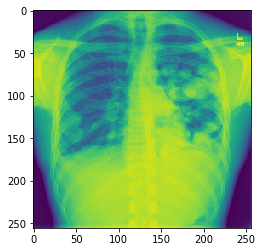

In [896]:
plt.imshow(np.squeeze(x[2]))

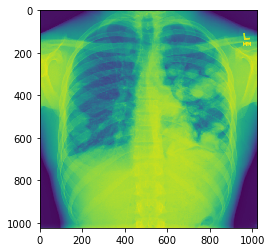

In [897]:
plt.imshow(pydicom.dcmread(train_df[1][2]).pixel_array)

In [898]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3, shuffle=True)

In [899]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

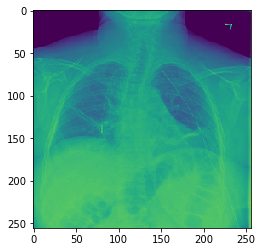

In [900]:
plt.imshow(np.squeeze(x[2])) #this will likely be a different image since we shuffled the data

In [901]:
train_df.head()

,0,1,2,3,4,5,6,7
0,0,data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,1,data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,2,data/train/00322d4d-1c29-4943-afc9-b6754be640e...,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,3,data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,4,data/train/00436515-870c-4b36-a041-de91049b9ab...,00436515-870c-4b36-a041-de91049b9ab4,562,152,256,453,1


In [902]:
train_df[1][4]

'data/train/00436515-870c-4b36-a041-de91049b9ab4.dcm'

In [903]:
im = pydicom.dcmread(train_df[1][4]).pixel_array

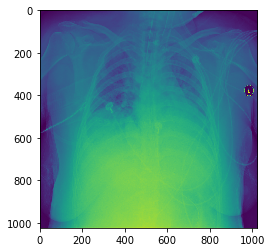

In [904]:
plt.imshow(im)

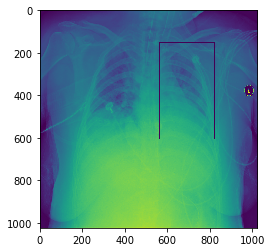

In [905]:
x1 = 562
y1 = 152
x2 = x1 + 256
y2 = y1 + 453
plt.imshow(cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,255), 2))

### Dataloader with x,y,width,height,class targets

In [906]:
im = cv2.resize(pydicom.dcmread(train_df[1][4]).pixel_array,(256,256))

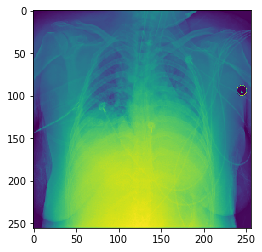

In [907]:
plt.imshow(im)

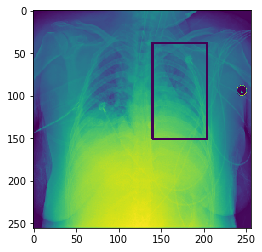

In [908]:
x1 = int(562/4)
y1 = int(152/4)
x2 = x1 + int(256/4)
y2 = y1 + int(453/4)
plt.imshow(cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,255), 2))

In [909]:
targets = np.asarray(train_df[[3,4,5,6,7]][:10]) #x,y,width,height,class

In [910]:
targets[:,:4] = targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

In [911]:
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3)

In [912]:
x,y = next(dl)
x,y = next(dl)

In [913]:
y[1]

array([140.,  38.,  64., 113.,   1.])

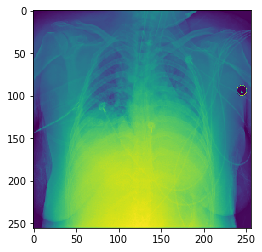

In [914]:
plt.imshow(np.squeeze(x[1]))

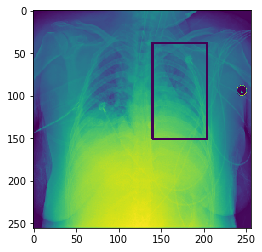

In [915]:
plt.imshow(
    cv2.rectangle(np.squeeze(x[1]), 
                  (int(y[1][0]), int(y[1][1])), 
                  (int(y[1][0]+y[1][2]), int(y[1][1]+y[1][3])), 
                  (0,255,255), 
                  2
    )
)

We are going to create a data loader that flips the images and targets randomly

In [1039]:
class Transform:

    @staticmethod
    def horizontal_flip(x, y):
        y[0] = 256 - y[0] - y[2]
        return np.flip(x, axis=1), y

    @staticmethod
    def vertical_flip(x, y):
        y[1] = 256 - y[1] - y[3]
        return np.flip(x, axis=0), y

    def __call__(self, x,y):
        if np.random.randint(0,2):
            x,y = self.horizontal_flip(x,y)
        if np.random.randint(0,2):
            x,y = self.vertical_flip(x,y)
        return x,y

In [1040]:
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=Transform.horizontal_flip)

In [1046]:
tfm = Transform()
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=tfm)

In [1047]:
x,y = next(dl)
x,y = next(dl)

In [1048]:
y[1]

array([ 52., 105.,  64., 113.,   1.])

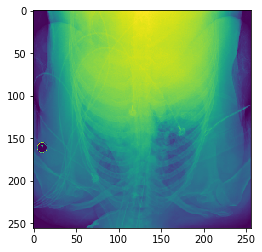

In [1049]:
plt.imshow(np.squeeze(x[1]))

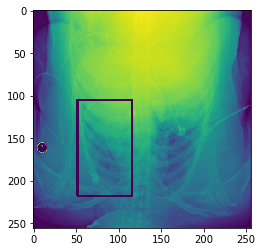

In [1050]:
plt.imshow(
    cv2.rectangle(np.squeeze(x[1]),
                  (int(y[1][0]), int(y[1][1])),
                  (int(y[1][0]+y[1][2]), int(y[1][1]+y[1][3])),
                  (0,255,255),
                  2
    )
)

a quick hack to get multiple targets into the format keras expects

In [1062]:
from functools import wraps

def hack(f):
    @wraps(f)
    def wrapper(*args,**kwargs):
        x,y = f(*args,**kwargs)
        return x, [y[:,:4], y[:,-1]]
    return wrapper

In [142]:
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=Transform.horizontal_flip)

NameError: name 'targets' is not defined

In [1065]:
tfm = Transform()
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=tfm)

In [1066]:
x,y = next(dl)
x,y = next(dl)

In [1067]:
y

[array([[ nan,  nan,  nan,  nan],
        [ 52., 105.,  64., 113.],
        [ nan,  nan,  nan,  nan]]), array([0., 1., 0.])]

In [1074]:
y[0][0][0]

nan

### Create Model Architecture

In [63]:
??Conv2D

In [82]:
n = int(1024/2)

input_layer = Input((256,256,1))
c1 = Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu')(input_layer)
b1 = BatchNormalization()(c1)
c2 = Conv2D(48, kernel_size=(5,5), strides=(2,2),activation='relu')(b1)
b2 = BatchNormalization()(c2)
c3 = Conv2D(64, kernel_size=(5,5), strides=(2,2),activation='relu')(b2)
b3 = BatchNormalization()(c3)
# c4 = Conv2D(128, kernel_size=(3,3), activation='relu')(c3)
a = MaxPooling2D(pool_size=(7,7),name='maxpool')(b3)
b = AveragePooling2D(pool_size=(7,7),name='avgpool')(c3)
x = concatenate([a,b], axis = -1)
flat = Flatten()(x)
d1 = Dense(n, activation='relu')(flat)
d2 = Dense(int(n/2), activation='relu')(d1)
d3 = Dense(int(n/4), activation='relu')(d2)
out = Dense(2, activation='softmax')(d3)
model = Model(inputs=input_layer, outputs= [out])

In [83]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 126, 126, 24) 624         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 126, 126, 24) 96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 61, 61, 48)   28848       batch_normalization_4[0][0]      
__________________________________________________________________________________________________
batch_norm

a quick hack to conver to categorical

In [158]:
from functools import wraps

def hack(f):
    @wraps(f)
    def wrapper(*args,**kwargs):
        x,y = f(*args,**kwargs)
        return x, to_categorical(y, num_classes=2)
    return wrapper

In [84]:
model.compile('adam', 'crossentropy', metrics=['acc'])

In [160]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3)

In [161]:
x,y = next(dl)

It is always a good idea to do a quick gut check with a subset of the data

In [85]:
bs = 64
epochs = 1
train_N = 10 #dataset size
valid_N = 10
train_dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=bs)
valid_dl = CustomImageDataLoader(valid_df[1][:10], valid_df[7][:10], bs=bs)

In [86]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = 1
)

Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 12.7539 - acc: 0.2000 - val_loss: 12.7539 - val_acc: 0.2000


It is always a good idea to do a quick gut check with a subset of the data

In [87]:
bs = 64
epochs = 5
train_N = len(train_df) #dataset size
valid_N = len(valid_df)
train_dl = CustomImageDataLoader(train_df[1], train_df[7], bs=bs)
valid_dl = CustomImageDataLoader(valid_df[1], valid_df[7], bs=bs)

In [88]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/1
349/349 [==============================] - 131s 376ms/step - loss: 12.4414 - acc: 0.2196 - val_loss: 12.9549 - val_acc: 0.1874


In [90]:
x,y = next(train_dl)

In [92]:
x.shape, y.shape

((64, 256, 256, 1), (64,))

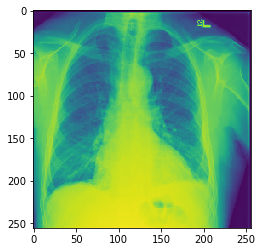

In [95]:
plt.imshow(np.squeeze(x[0]))

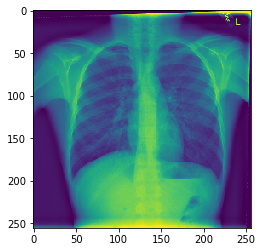

In [96]:
plt.imshow(np.squeeze(x[1]))

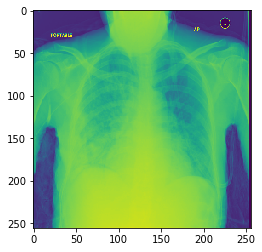

In [97]:
plt.imshow(np.squeeze(x[2]))

In [94]:
y[:10]

array([1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])

In [100]:
out = model.predict(x)

In [101]:
out

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

#### Loss

https://keras.io/losses/

https://github.com/keras-team/keras/blob/master/keras/losses.py

quick demo of tf mask to remove nans from loss func

In [1083]:
K.eval(K.variable(y[0]))

array([[ nan,  nan,  nan,  nan],
       [ 52., 105.,  64., 113.],
       [ nan,  nan,  nan,  nan]], dtype=float32)

In [1081]:
K.eval(tf.is_nan(K.variable(y[0])))

array([[ True,  True,  True,  True],
       [False, False, False, False],
       [ True,  True,  True,  True]])

In [1085]:
yt = K.variable(y[0])
mask = tf.logical_not(tf.is_nan(yt))
K.eval(tf.boolean_mask(yt, mask))

array([ 52., 105.,  64., 113.], dtype=float32)

In [ ]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
def mean_squared_error_no_nan(y_true, y_pred):
    mask = tf.logical_not(tf.is_nan(y_true))
    return mean_squared_error(tf.boolean_mask(y_true, mask), tf.boolean_mask(y_pred, mask))

### Train Model

### Create Submission